In [1]:
%matplotlib inline

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
import numpy as np
import pandas as pd
from functools import reduce
from itertools import combinations
from keras.layers import Input
from keras.models import Model
from keras.utils import plot_model

Using TensorFlow backend.


In [157]:
def transformCards(cards):
    T = np.zeros((12,3)).astype("int32")
    T[np.arange(12), cards.reshape(3*4)] = 1
    R = T.reshape(3,4,3)
    
    return R

In [158]:
def generateCard(): return np.random.randint(0,3,4).astype("int32")

In [159]:
def generateSet():
    A = generateCard()
    B = generateCard()
    return transformCards(np.array([A,B,(3-(A+B)%3)%3]).astype("int32"))

In [160]:
def isSet(cards):
    return (cards.sum(axis=0)%3).sum()==0

In [161]:
def generateNonSet():
    A = generateCard()
    B = generateCard()
    while True:
        C = generateCard()
        cards = np.array([A,B,C])
        if not isSet(cards):
            return transformCards(cards)

In [162]:
def generateDataset(N):
    Y = np.random.randint(0,2,N)
    X1 = np.array([generateSet() for _ in range(N)])
    X2 = np.array([generateNonSet() for _ in range(N)])
    return Y.reshape(N,1,1,1)*X1+(1-Y.reshape(N,1,1,1))*X2, Y

In [163]:
Xtrain, Ytrain = generateDataset(2000)

In [164]:
Xtest, Ytest = generateDataset(1000)

In [172]:
def SetNet(inputLayer):
    X = [keras.layers.Lambda(lambda x: x[:, :, i, :])(inputLayer) for i in range(4)]
    X = [keras.layers.Reshape((9,))(c) for c in X]
    
    layer_1 = Dense(9, activation='relu')
    layer_2 = Dense(4, activation='relu')
    layer_3 = Dense(1, activation='sigmoid')
    
    X = [layer_1(c) for c in X]
    X = [layer_2(c) for c in X]
    X = [layer_3(c) for c in X]
    
    X = keras.layers.Multiply()(X)
    X = Dense(1, activation='sigmoid')(X)
    
    return X

In [173]:
inputLayer = Input((3,4,3))
outputLayer = SetNet(inputLayer)

In [174]:
model = Model(inputs=inputLayer, outputs=outputLayer)

In [175]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [176]:
hist = model.fit(Xtrain, Ytrain,
          epochs=200,
          verbose=0,
          validation_data=(Xtest, Ytest))

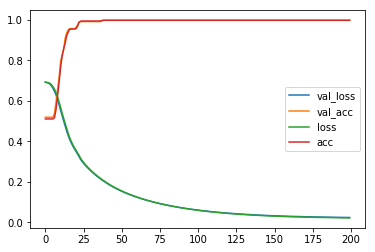

In [177]:
pd.DataFrame(hist.history).plot()

In [178]:
model.evaluate(Xtest, Ytest, verbose=0)

[0.024436367213726044, 0.997]

In [27]:
plot_model(model, show_shapes=True, to_file="file.png", show_layer_names=True)